In [1]:
# !kaggle datasets download -d hijest/genre-classification-dataset-imdb

In [2]:
# import zipfile
# import os

# # Define the path to the ZIP file and the extraction directory
# zip_file_path = 'genre-classification-dataset-imdb.zip'
# extraction_dir = 'genre-classification-dataset-imdb'

# # Create the extraction directory if it doesn't exist
# os.makedirs(extraction_dir, exist_ok=True)

# # Extract the ZIP file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_dir)

# print(f'Extracted {zip_file_path} to {extraction_dir}')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import string
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the training data
train_data_path = r"/content/drive/MyDrive/CodSoft/train_data.txt"
train_data = pd.read_csv(train_data_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [6]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
#check for each column values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [8]:
#statistical analysis
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [9]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [10]:
test_data_path = r"/content/drive/MyDrive/CodSoft/test_data.txt"
test_data = pd.read_csv(test_data_path, sep=':::', names=['Title', 'Description'], engine='python')

In [11]:
test_data.head()

,Title,Description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


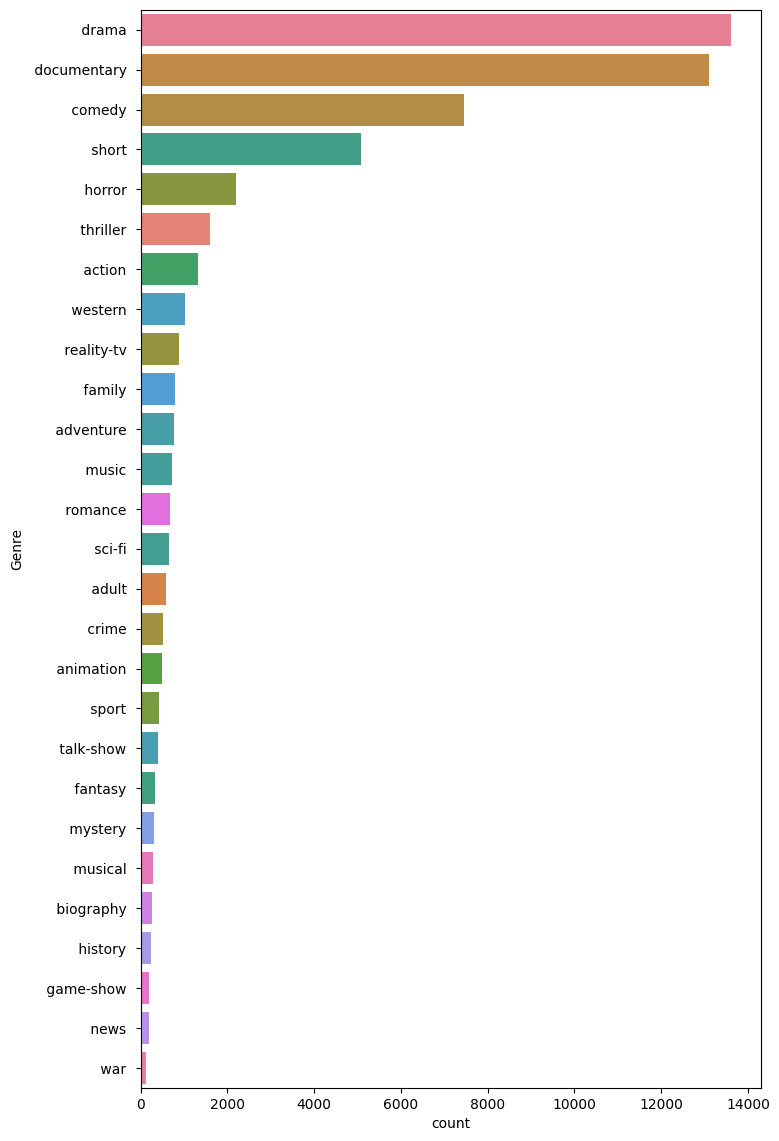

In [12]:
plt.figure(figsize=(8, 14))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, hue='Genre')
plt.show()

Here, we can see that the train data consists of drama, documentry and comedy type movies in most.

In [13]:
train_data.Description

1         Listening in to a conversation between his do...
2         A brother and sister with a past incestuous r...
3         As the bus empties the students for their fie...
4         To help their unemployed father make ends mee...
5         The film's title refers not only to the un-re...
                               ...                        
54210     This short-lived NBC live sitcom centered on ...
54211     The NEXT Generation of EXPLOITATION. The sist...
54212     Ze bestaan echt, is a stand-up comedy about g...
54213     Walter and Vivian live in the country and hav...
54214     On Labor Day Weekend, 1935, the most intense ...
Name: Description, Length: 54214, dtype: object

In [20]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
# Initialize the stemmer and stop words
stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text) #remove image links or similar patterns that start with "pic"
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # keep words only with length>1
    text = "".join([i for i in text if i not in string.punctuation])
    words = word_tokenize(text)
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


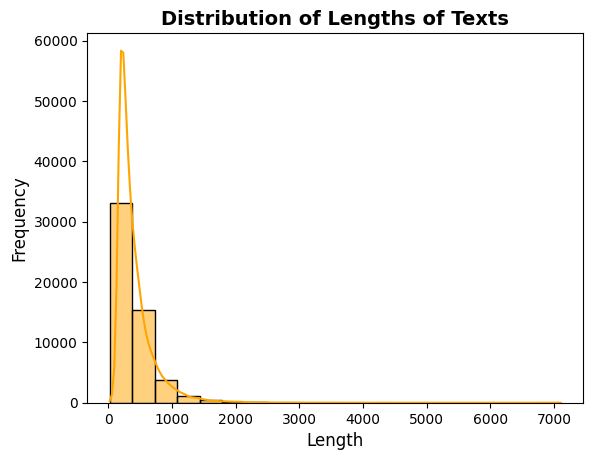

In [21]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure()
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='orange')
plt.xlabel('Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Lengths of Texts', fontsize=14, fontweight='bold')
plt.show()

In [22]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

In [23]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
from sklearn.svm import SVC
classifier = SVC(kernel='linear', C=1.0, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.5396108088167482


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.33      0.20      0.25       263
       adult        0.54      0.24      0.33       112
   adventure        0.29      0.12      0.16       139
   animation        0.23      0.05      0.08       104
   biography        0.00      0.00      0.00        61
      comedy        0.45      0.51      0.48      1443
       crime        0.33      0.02      0.04       107
 documentary        0.64      0.82      0.72      2659
       drama        0.51      0.73      0.60      2697
      family        0.32      0.08      0.13       150
     fantasy        1.00      0.01      0.03        74
   game-show        0.83      0.38      0.52        40
     history        0.00      0.00      0.00        45
      horror        0.56      0.52      0.54       431
       music        0.56      0.41      0.47       144
     musical        0.36      0.08      0.13        50
     mystery        1.00      0.04      0.07        56
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [25]:
classifier.score(X_train, y_train)

0.5959742685204399